In [22]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
#%matplotlib notebook

In [23]:
fileIn = "chr19_2000_sorted_continuous_genome_gc.tsv"


In [24]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [25]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [26]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [27]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0000001])
    opt.set_upper_bounds([0.5])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return([testChr[0],res[0]])

In [28]:
def calc_single_dist(x,rbp):
    d,h0,h1,h2,th = x
    
    r = rbp*(d)
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [29]:
def single_chr_obj_fun(x_,arr):
    rbp= x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [42]:
def calc_single_dist_gc(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [43]:
def single_chr_obj_fun_gc(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist_gc(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [30]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [31]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['sample']==1) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [32]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [33]:
def find_max_like_group_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [34]:
def combine_across_individuals_and_replicates(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    numReplicates = len(test['replicate'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/(numSamples*numReplicates)
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [16]:
df = pd.read_csv(fileIn,delimiter='\t')

In [18]:
df = pd.read_csv(fileIn,delimiter='\t')
df = df.loc[ df['chromosome'] != 'X']
df = df.astype({'chromosome':'int64'})

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [19]:
df

,Unnamed: 0,sample,replicate,chromosome,h_0,h_1,h_2,total,h_0_frac,h_1_frac,h_2_frac,H
0,1,1,1,19,27597714,399470,2815,27999999,0.985633,0.014267,0.000101,0.007234
1,2,1,1,19,27597760,399376,2862,27999998,0.985634,0.014263,0.000102,0.007234
2,3,1,1,19,27597686,399522,2789,27999997,0.985632,0.014269,0.000100,0.007234
3,4,1,1,19,27597693,399506,2797,27999996,0.985632,0.014268,0.000100,0.007234
4,5,1,1,19,27597769,399352,2874,27999995,0.985635,0.014263,0.000103,0.007234
...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1996,10,100,19,27595741,400481,1782,27998004,0.985632,0.014304,0.000064,0.007216
1999996,1997,10,100,19,27595774,400413,1816,27998003,0.985634,0.014301,0.000065,0.007216
1999997,1998,10,100,19,27595699,400561,1742,27998002,0.985631,0.014307,0.000062,0.007216
1999998,1999,10,100,19,27595800,400357,1844,27998001,0.985635,0.014299,0.000066,0.007216


In [46]:
modelTruth = [0.00144168 for d in list(range(0,2000))]
modelConstant = [ 0.00144168 for x in list(range(2000))]
modelEstimatedChr19CombinedReps =  [0.0013988449096676617 for d in list(range(0,2000))]
#we won't use this below, so just make them equal for now:
#modelEstimatedChr19WithGC = [rho(0.0014578211661126998,0.0010329106648468952, 33.196417210391864,d+1)/(d+1) for d in list(range(0,2000))]


In [63]:
testChr = 19
modelTruth = [rho(0.00144168,0.00356648,200,d+1)/(d+1) for d in list(range(0,2000))]
modelConstant = [ 0.00144168 for x in list(range(2000))]
#modelEstimatedGloballyAsMedian = [rho(0.00164344,0.0038803,167.4,d+1)/(d+1) for d in list(range(0,2000))]
modelEstimatedChr19CombinedReps = [rho(0.0013918962900349783,0.003558959149111771,201,d+1)/(d+1) for d in list(range(0,2000))]


##### Here we are trying a single iteration

In [48]:
testChr =  df.loc[(df['chromosome']== 19) & (df['replicate']==10) & (df['sample']==5)& (df['Unnamed: 0']<=2000)] 
testChr = testChr.iloc[:,[0,4,5,6,11]].to_numpy()

In [49]:
jobs = [[x+1,testChr[x]] for x in list(range(0,500))]
with Pool(cpu_count()) as p:
    thisResOneInd = p.map(find_max_like_single_dist,jobs)
thisResOneInd = [x[1] for x in thisResOneInd]

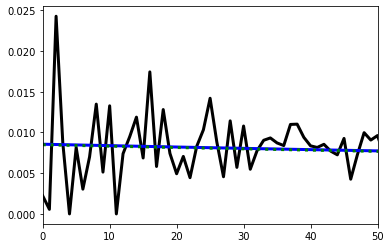

In [64]:
plt.plot(thisResOneInd,"k",linewidth=3)
plt.plot(modelTruth,"b",linewidth=3)
#plt.plot(modelConstant,"y",linewidth=3)
#plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"g:",linewidth=3)
#plt.plot(modelEstimatedChr19WithGC,"r:",linewidth=3)

plt.xlim([0,50])
plt.show()

Here combining across individuals to get an estimate of Rho/d (r/bp) for each distance  

In [73]:
testPooled = df.loc[(df['chromosome']==19) & (df['replicate']<= 100) & (df['Unnamed: 0']<=2000)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

In [77]:
jobs = [[x+1,testPooled[x]] for x in list(range(1000))]
with Pool(cpu_count()) as p:
    thisRes = p.map(find_max_like_single_dist,jobs)
thisRes = [x[1] for x in thisRes]

In [78]:
print(thisRes)

[0.008808484210180522, 0.00882743230211298, 0.007825123080705132, 0.007017714436617408, 0.009568868064289308, 0.0076918801525441265, 0.008088505403521405, 0.00799685347400631, 0.00798179992052799, 0.008515270138917097, 0.0077831503524807555, 0.007868194337485205, 0.008398683656885965, 0.008035078292996527, 0.008294564278599871, 0.008127977850527074, 0.008005190733610808, 0.008149656156769143, 0.008452087891624091, 0.008092407448580608, 0.008495815685415267, 0.00784205865121726, 0.008122362224063824, 0.008105417722162856, 0.007939941617581497, 0.008214260713365921, 0.007766970740053308, 0.007747906075898945, 0.007896309837969174, 0.0077620928261426525, 0.008004505587831664, 0.007992590619210708, 0.008005137787973385, 0.00788448909454073, 0.008073891329325249, 0.007996424005889895, 0.007962896169956643, 0.00794642404727663, 0.007730741832893207, 0.007718989567676436, 0.007944793427279337, 0.007683731142481918, 0.007667136031872025, 0.007758691052436827, 0.007549840817567781, 0.0077155654

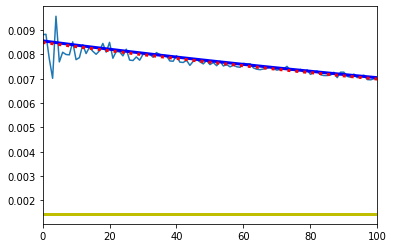

In [79]:
plt.plot(thisRes)
plt.plot(modelTruth,"b",linewidth=3)
plt.plot(modelConstant,"y",linewidth=3)
#plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"r:",linewidth=3)
#plt.plot(modelEstimatedChr19WithGC,"k:",linewidth=3)
plt.xlim([0,100])
plt.show()